In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import h5py
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import TensorBoard, ModelCheckpoint
import datetime

import numpy as np

def get_file_name ():
    now = datetime.datetime.now()
    return "%d%d%d-%d%d" % (now.year, now.month, now.day, now.hour, now.minute)

def get_tensor_board () :
    return TensorBoard(log_dir='./logs/' + get_file_name()  + '/', histogram_freq=0,
                          write_graph=True, write_images=False)


## Configure everything (hard coded .a.t.m.)
nr_labels = 5 
batch_size = 32
nr_epochs = 2
num_samples = 3620
num_valid_samples = 50


Using TensorFlow backend.


Found 3620 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Image batch shape:  (32, 150, 150, 3)
Labe batch shape:  (32, 5)


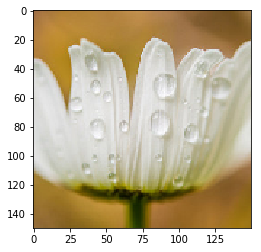

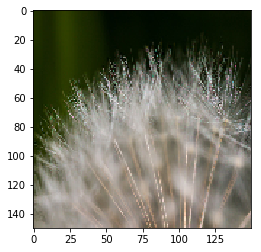

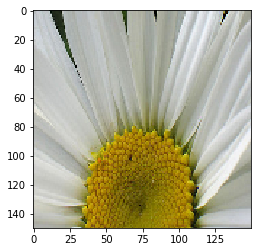

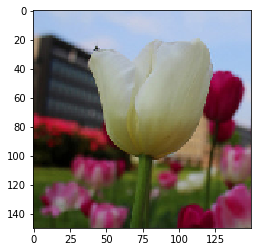

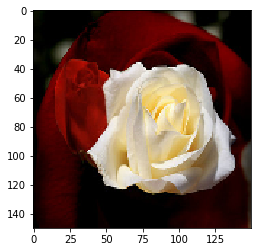

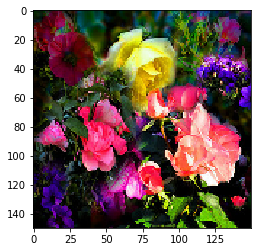

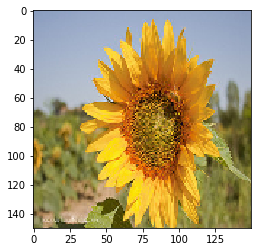

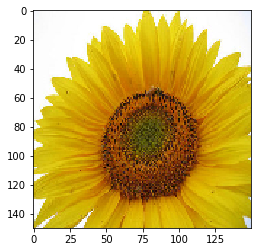

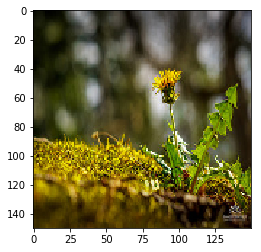

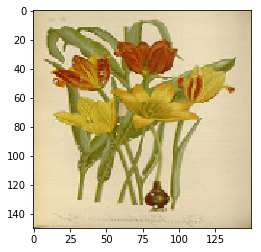

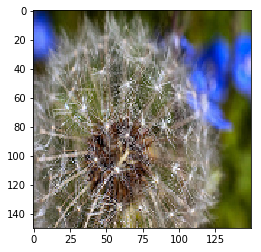

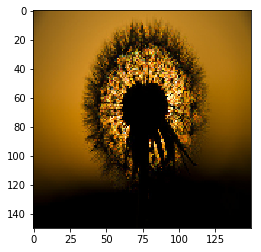

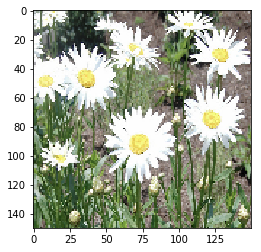

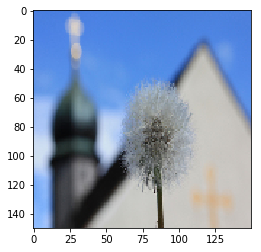

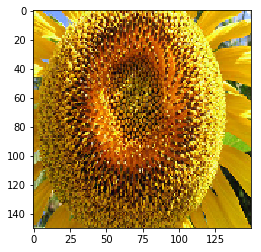

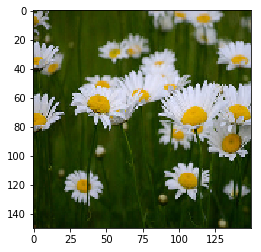

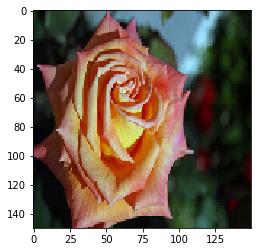

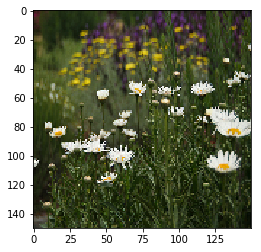

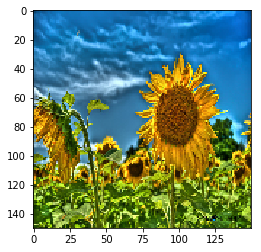

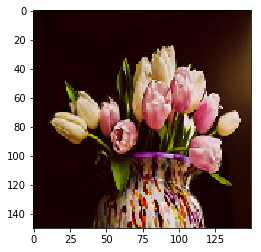

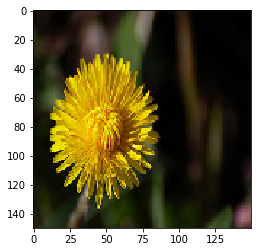

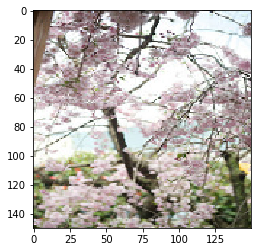

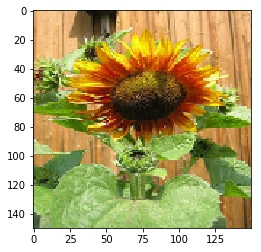

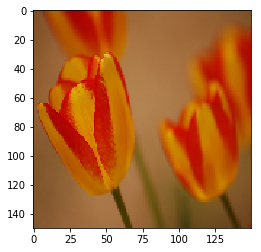

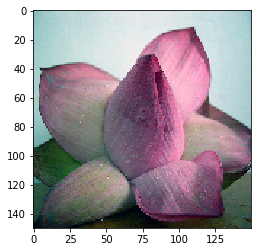

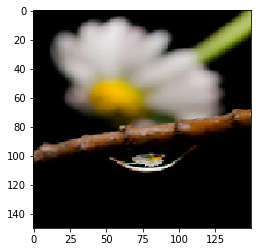

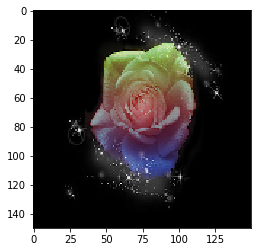

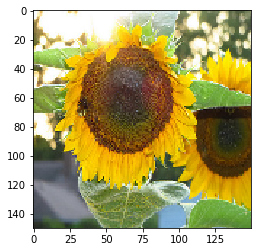

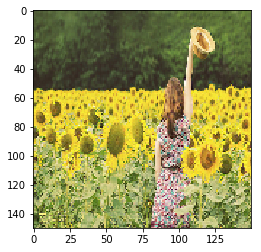

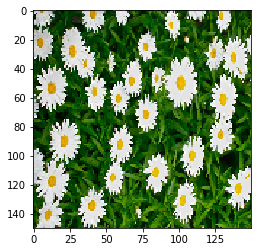

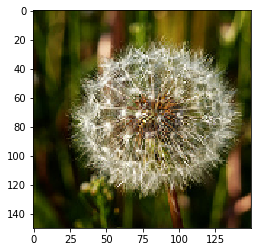

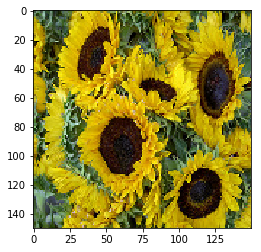

In [2]:
def get_generator (folder, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        folder,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    
    return train_generator
train_generator = get_generator('flower_photos_splitted/train', batch_size=batch_size)
valid_generator = get_generator('flower_photos_splitted/valid', batch_size=batch_size)

for image_batch,label_batch in valid_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  for image in image_batch:
    plt.imshow(image)
    plt.show()
  break

In [5]:

def get_model ():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(nr_labels, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in model.layers[:1]:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = get_model()
model.load_weights('models/model.h5') 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [6]:

print('evaluate')
loss = model.evaluate_generator(valid_generator, 
                    steps= num_valid_samples / batch_size)
print(loss)



evaluate
[0.2517941677570343, 0.9000000023841858]


dandelion


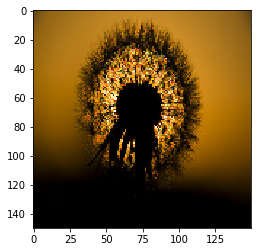

sunflowers


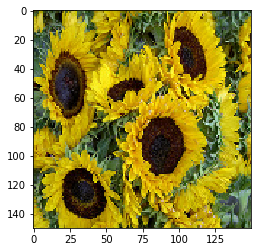

dandelion


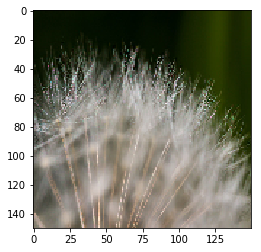

dandelion


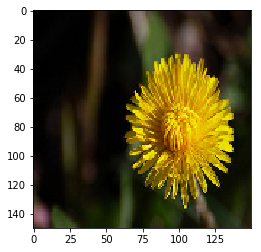

roses


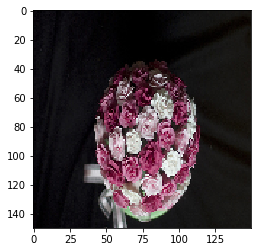

dandelion


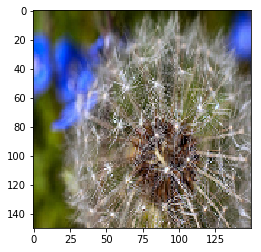

sunflowers


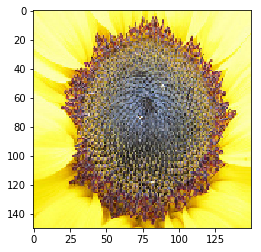

roses


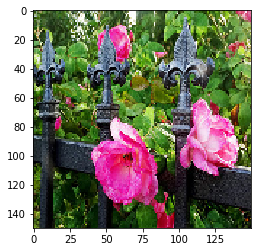

daisy


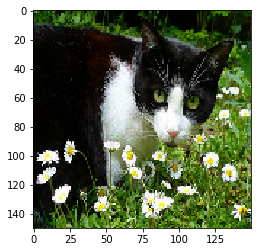

daisy


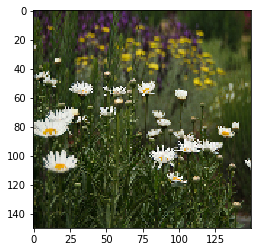

roses


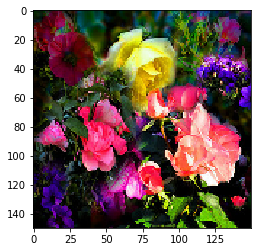

sunflowers


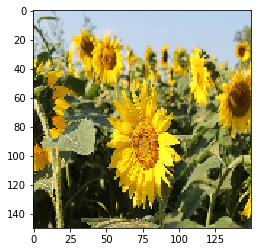

tulips


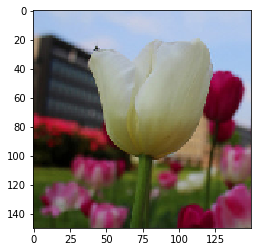

roses


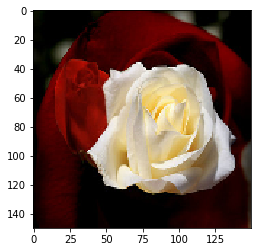

daisy


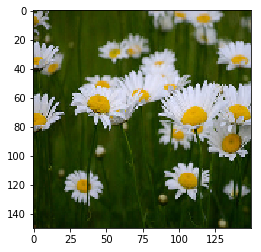

sunflowers


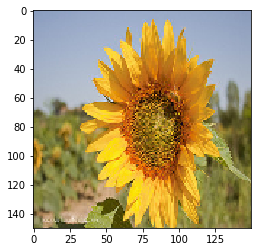

roses


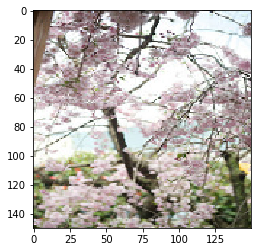

daisy


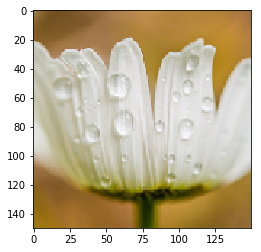

tulips


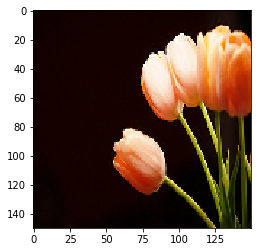

tulips


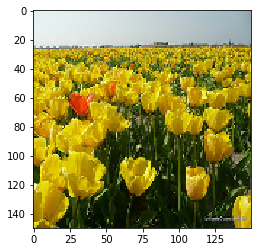

daisy


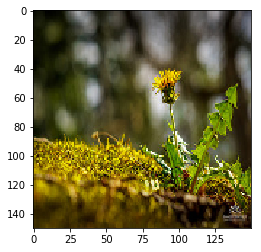

sunflowers


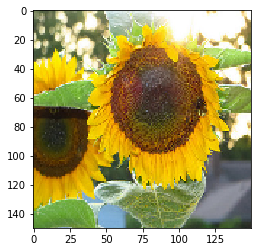

dandelion


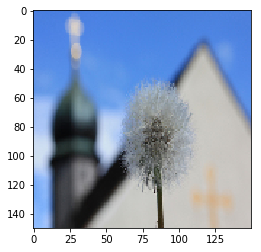

roses


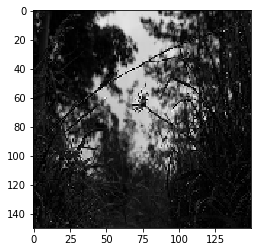

tulips


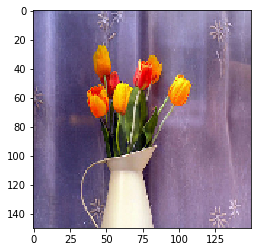

dandelion


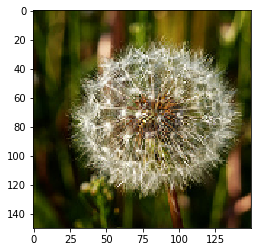

sunflowers


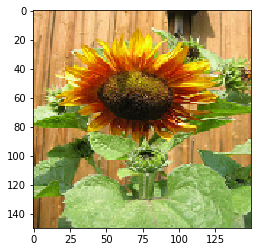

tulips


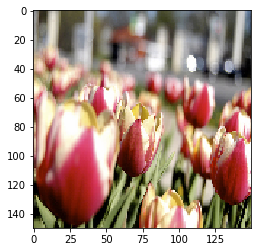

roses


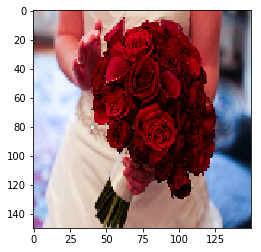

sunflowers


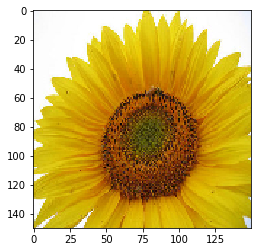

roses


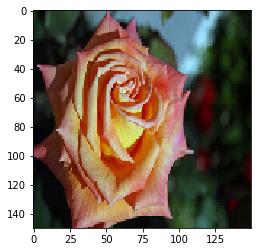

roses


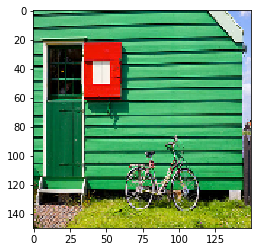

In [7]:
classes = valid_generator.classes
class_indices = valid_generator.class_indices
class_names = {}
for k, v in class_indices.items():
    class_names[v] = k
    
for image_data, something_else in valid_generator:
    res = model.predict(image_data)
    for index, image in enumerate(image_data):
        predicted_class = np.argmax(res[index], axis=-1)
        print(class_names[predicted_class])
        plt.imshow(image)
        plt.show()
    break

In [10]:

print('train')
model.fit_generator(train_generator, 
                    epochs=100,
                    steps_per_epoch= 1, #num_samples / batch_size, 
                    validation_data=valid_generator,
                    validation_steps = 1, #,num_valid_samples / batch_size,
                    callbacks=[
                        get_tensor_board(),
                        ModelCheckpoint('models/%s.h5'% get_file_name(), verbose=1, save_best_only=True)
                    ])



train
Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 0.5348 - acc: 0.8438 - val_loss: 3.1170 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 3.11700, saving model to models/2019412-2239.h5
Epoch 2/100
1/1 [==============================] - 11s 11s/step - loss: 0.5978 - acc: 0.8750 - val_loss: 2.3904 - val_acc: 0.6667

Epoch 00002: val_loss improved from 3.11700 to 2.39041, saving model to models/2019412-2239.h5
Epoch 3/100
1/1 [==============================] - 12s 12s/step - loss: 0.7835 - acc: 0.7188 - val_loss: 2.0833 - val_acc: 0.6250

Epoch 00003: val_loss improved from 2.39041 to 2.08332, saving model to models/2019412-2239.h5
Epoch 4/100


KeyboardInterrupt: 